In [ ]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, row_number, dense_rank
from pyspark.sql.window import Window

# Create a SparkSession
spark = SparkSession.builder.appName("Amazon Recommendation System").getOrCreate()

# Read the CSV files into DataFrames
amazon_df = spark.read.format("csv").option("header", "true").load("/content/gdrive/MyDrive/ratings_Electronics (1)_new.csv")



In [ ]:
amazon_df.show(10)

+--------------+----------+------+----------+
|       User_ID|Product_ID|Rating| Timestamp|
+--------------+----------+------+----------+
|A2CX7LUOHB2NDG|0321732944|     5|1341100800|
|A2NWSAGRHCP8N5|0439886341|     1|1367193600|
|A2WNBOD3WNDNKT|0439886341|     3|1374451200|
|A1GI0U4ZRJA8WN|0439886341|     1|1334707200|
|A1QGNMC6O1VW39|0511189877|     5|1397433600|
|A3J3BRHTDRFJ2G|0511189877|     2|1397433600|
|A2TY0BTJOTENPG|0511189877|     5|1395878400|
|A34ATBPOK6HCHY|0511189877|     5|1395532800|
| A89DO69P0XZ27|0511189877|     5|1395446400|
| AZYNQZ94U6VDB|0511189877|     5|1401321600|
+--------------+----------+------+----------+
only showing top 10 rows



Checking the type of each column

In [ ]:
amazon_df.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Timestamp: string (nullable = true)



Checking for NULL values

In [ ]:
# Checking null values in each column
null_values = amazon_df.select([count(when(col(c).isNull(), c)).alias(c) for c in amazon_df.columns])

# Showing null values
null_values.show()

+-------+----------+------+---------+
|User_ID|Product_ID|Rating|Timestamp|
+-------+----------+------+---------+
|      0|         0|     0|        0|
+-------+----------+------+---------+



Neither of the columns have null values, so we will not perform any imputations over here.

Getting a summary of statistics

In [ ]:
# Changing the type of 'Rating column to integer'
column_name = ['Rating']

for N in column_name:
    amazon_df = amazon_df.withColumn(N, col(N).cast('integer'))


In [ ]:
# Displaying the statistics
amazon_df.select(column_name).describe().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|           1048575|
|   mean|3.9733791097441764|
| stddev| 1.399329495191631|
|    min|                 1|
|    max|                 5|
+-------+------------------+



For Modelling, we would need all the columns in our data to be numeric.After checking the Product_ID we understood that it had a lot of non-numeric charaters, so we created a new column "New_Product_ID" where all the values are numeric.

In [ ]:
windowSpec = Window.orderBy("Product_ID")
amazon_df = amazon_df.withColumn("New_Product_ID", dense_rank().over(windowSpec))
# Showing the DataFrame after the conversion
amazon_df.show(10)

+--------------+----------+------+----------+--------------+
|       User_ID|Product_ID|Rating| Timestamp|New_Product_ID|
+--------------+----------+------+----------+--------------+
|A2CX7LUOHB2NDG|0321732944|     5|1341100800|             1|
|A2NWSAGRHCP8N5|0439886341|     1|1367193600|             2|
|A2WNBOD3WNDNKT|0439886341|     3|1374451200|             2|
|A1GI0U4ZRJA8WN|0439886341|     1|1334707200|             2|
|A1QGNMC6O1VW39|0511189877|     5|1397433600|             3|
|A3J3BRHTDRFJ2G|0511189877|     2|1397433600|             3|
|A2TY0BTJOTENPG|0511189877|     5|1395878400|             3|
|A34ATBPOK6HCHY|0511189877|     5|1395532800|             3|
| A89DO69P0XZ27|0511189877|     5|1395446400|             3|
| AZYNQZ94U6VDB|0511189877|     5|1401321600|             3|
+--------------+----------+------+----------+--------------+
only showing top 10 rows



Similarly, After checking the user_ID we understood that it had a lot of non-numeric charaters, so we created a new column "New_User_ID" where all the values are numeric.



In [ ]:
windowSpec = Window.orderBy("user_ID")
amazon_df = amazon_df.withColumn("New_User_ID", dense_rank().over(windowSpec))

# Showing the DataFrame after the conversion
amazon_df.show(10)

+--------------------+----------+------+----------+--------------+-----------+
|             User_ID|Product_ID|Rating| Timestamp|New_Product_ID|New_User_ID|
+--------------------+----------+------+----------+--------------+-----------+
|A00037441I8XOQJSU...|B000I3C624|     5|1356220800|         61009|          1|
|A00038802J7X43YTW...|B0007NWLXO|     1|1397433600|         36802|          2|
|A00038802J7X43YTW...|B000EGGPM2|     5|1368662400|         50901|          2|
|A000428226SAAAIBK...|B000CRT07U|     5|1388793600|         48904|          3|
|A0004478EF5NFPHLGCWG|B00012F6A6|     4|1358380800|         23088|          4|
|A000681618A3WRMCK53V|B0002Y5WZM|     2|1383609600|         31640|          5|
|A00101847G3FJTWYGNQA|B0002JFOQO|     5|1385769600|         29836|          6|
|A00124802J36AVPT3...|B00008N6Y8|     1|1396224000|         15580|          7|
|A00151102CWWUCLQH...|B000EMCZ52|     5|1397433600|         51495|          8|
|A0015232111B3971D...|B0000C73CQ|     3|1387756800| 

Checking the types of the new columns

In [ ]:
amazon_df.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- New_Product_ID: integer (nullable = false)
 |-- New_User_ID: integer (nullable = false)



Re-checking for NULL values

In [ ]:
# Checking null values in each column
null_values = amazon_df.select([count(when(col(c).isNull(), c)).alias(c) for c in amazon_df.columns])

# Showing nul values
null_values.show()

+-------+----------+------+---------+--------------+-----------+
|User_ID|Product_ID|Rating|Timestamp|New_Product_ID|New_User_ID|
+-------+----------+------+---------+--------------+-----------+
|      0|         0|     0|        0|             0|          0|
+-------+----------+------+---------+--------------+-----------+



### EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
pandas_df = amazon_df.toPandas()

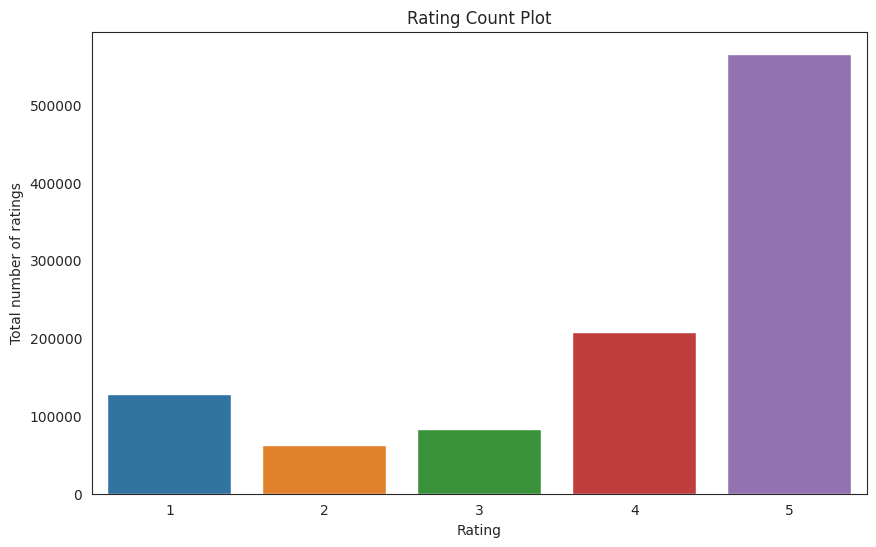

In [ ]:
with sns.axes_style('white'):
    plt.figure(figsize=(10, 6))
    sns.countplot(x="Rating", data=pandas_df)
    plt.ylabel("Total number of ratings")
    plt.title("Rating Count Plot")

# Show the plot
plt.show()

Dropping the Timestamp column, as it does not have much relevance in our recommendation system.

In [ ]:
amazon_df = amazon_df.drop("Timestamp")

In [ ]:
amazon_df.show(10)

+--------------------+----------+------+--------------+-----------+
|             User_ID|Product_ID|Rating|New_Product_ID|New_User_ID|
+--------------------+----------+------+--------------+-----------+
|A00037441I8XOQJSU...|B000I3C624|     5|         61009|          1|
|A00038802J7X43YTW...|B0007NWLXO|     1|         36802|          2|
|A00038802J7X43YTW...|B000EGGPM2|     5|         50901|          2|
|A000428226SAAAIBK...|B000CRT07U|     5|         48904|          3|
|A0004478EF5NFPHLGCWG|B00012F6A6|     4|         23088|          4|
|A000681618A3WRMCK53V|B0002Y5WZM|     2|         31640|          5|
|A00101847G3FJTWYGNQA|B0002JFOQO|     5|         29836|          6|
|A00124802J36AVPT3...|B00008N6Y8|     1|         15580|          7|
|A00151102CWWUCLQH...|B000EMCZ52|     5|         51495|          8|
|A0015232111B3971D...|B0000C73CQ|     3|         21221|          9|
+--------------------+----------+------+--------------+-----------+
only showing top 10 rows



## **Alternate least square method**

In [ ]:
#Dividing the Data into Training and Test
(training, test) = amazon_df.randomSplit([0.70, 0.30], seed=97)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS



In [ ]:
als = ALS(maxIter=8, regParam=0.1, coldStartStrategy="drop", userCol="New_User_ID", itemCol="New_Product_ID", ratingCol="Rating")
model = als.fit(training)

In [ ]:
# Fitting the model on Test Data
als_model = als.fit(test)

# Making prediction
predicted_rating = als_model.transform(test)

#Displaying Predictions
predicted_rating.show()


+--------------------+----------+------+----------+--------------+-----------+----------+
|             User_ID|Product_ID|Rating| Timestamp|New_Product_ID|New_User_ID|prediction|
+--------------------+----------+------+----------+--------------+-----------+----------+
|A0015232111B3971D...|B0000C73CQ|     3|1387756800|         21221|          9| 2.9409244|
|A00328401T70RFN4P...|B000I68BD4|     3|1355788800|         61285|         16| 2.8474588|
|A00328742CDZTXNDC...|B0001FTVEK|     1|1399593600|         24439|         17| 0.9519777|
|A00471742QKXLMG5C...|B0000C73CQ|     4|1380067200|         21221|         20| 3.9212327|
|A00472882AAY7AC6O...|B0000DHVN3|     5|1355184000|         21787|         22|  4.881806|
|A00593764YDL3YS9LG2G|B000ANOY7M|     5|1363046400|         43802|         26| 4.8695745|
|A00625243BI8W1SSZ...|B0000645RH|     4|1362787200|          9224|         28| 3.8466115|
|A00716392HKH0FTDS...|B000HDFXU2|     5|1361318400|         59528|         31| 4.9355693|
|A00766851

In [ ]:
# Calculating RMSE and evaluating the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE:", rmse)

RMSE: 0.1311862440744296


We have got a score RMSE score of 0.103, which is good for our model.

## Building a Model on Collaborative filtering using ALS

In [ ]:
distinct_user_ID = amazon_df.select('New_User_ID').distinct().rdd.flatMap(lambda x: x)
distinct_user_ID.collect()


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [ ]:
distinct_users_df = spark.createDataFrame([(user,) for user in Distinct_user_ID ], ['user_id'])

TypeError: ignored

In [ ]:
num_recommendations = 2
user_recommendations = als_model.recommendForUserSubset(distinct_users_df, num_recommendations)

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType

In [ ]:
extract_Product_ids = udf(lambda x: [row.New_Product_ID for row in x], ArrayType(IntegerType()))
user_recommendations = user_recommendations.withColumn('New_Product_ID', extract_Product_ids(col('recommendations'))) \
                                            .drop('recommendations')


In [ ]:
user_recommendations.show(10)

+-----------+--------------+
|New_User_ID|New_Product_ID|
+-----------+--------------+
|          6|[29836, 57653]|
|         12|[59453, 21733]|
|         13|[59087, 21560]|
|         22| [30864, 3450]|
|         27| [47709, 2410]|
|         28|  [5416, 6343]|
|         31|[10263, 41298]|
|         44| [4281, 19752]|
|         52| [6952, 61622]|
|         81| [8134, 12821]|
+-----------+--------------+
only showing top 10 rows



Using Popularity Method

In [ ]:
from pyspark.sql.functions import avg, lit, col, coalesce
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data into training and testing sets
train_df, test_df = amazon_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Calculate the global mean rating
global_mean = train_df.agg(avg('Rating')).first()[0]

In [ ]:
# Calculate the mean rating for each user and item in the training set
user_means = train_df.groupBy('New_User_ID').agg(avg('Rating').alias('user_mean'))
item_means = train_df.groupBy('New_Product_ID').agg(avg('Rating').alias('item_mean'))

In [ ]:
# Compute the deviations from the global average for each user and product
user_deviations = user_means.rdd.map(lambda row: (row['New_User_ID'], row['user_mean'] - global_mean)).collectAsMap()
product_deviations = item_means.rdd.map(lambda row: (row['New_Product_ID'], row['item_mean'] - global_mean)).collectAsMap()


In [ ]:
def predict_rating(New_User_ID, New_Product_ID):
    user_deviation = user_deviations.get(New_User_ID, 0)
    product_deviation = product_deviations.get(New_Product_ID, 0)
    return global_mean + user_deviation + product_deviation

In [ ]:
# Convert the training set to a dataframe
train_df = train_df.selectExpr(' userId', 'itemId', 'rating')

In [ ]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
# Add a column for the predicted rating to the test set
predict_rating_udf = udf(predict_rating, FloatType())
test_df = test_df.withColumn('predicted_rating', predict_rating_udf('New_User_ID', 'New_Product_ID'))


In [ ]:
# Compute the RMSE on the test set
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Rating', predictionCol='predicted_rating')
rmse = evaluator.evaluate(test_df)
print(f'RMSE: {rmse}')

RMSE: 1.414356516017903
